In [1199]:
from collections import Counter
import numpy as np
import pandas as pd
from scipy.special import comb

import torch
from torch.distributions import constraints
import pyro
import pyro.infer
import pyro.optim 
import pyro.distributions as dist

import seaborn as sns


pyro.set_rng_seed(10)

import matplotlib.pyplot as plt

%matplotlib inline

# Normal Distribution Experiments

In [129]:
# Simple normal distribution.
mean = 1.
scale = 1. # Variance.

normal = torch.distributions.Normal(mean, scale)

In [172]:
x = normal.rsample()

# Getting the probability of each point from PDF
# log_prob avaiable default, for actual one, raise it.
2 ** normal.log_prob(x)



tensor(0.1791)

In [163]:
# torch.log2(torch.Tensor([0.0000000001]))

In [178]:
pyro.distributions.Dirichlet

# Pyro's way of writing the random variable.

flag = pyro.sample("weather", pyro.distributions.Bernoulli(0.3))


tensor(0.)

In [207]:
def weather():
    """
    These are stochastic functions or non-diterministic in nature, because
    of the embedded randomness in it.
    
    Here the two random variables are involved, cloudy and temp, its
    parameters are hardcoded, or already learned.
    """
    cloudy = pyro.sample("cloudy", pyro.distributions.Bernoulli(0.3))
    weather = "cloudy" if cloudy == 1.0 else "sunny"
    
    mean_temp = {"cloudy": 23, "sunny": 30}[weather]
    scale_temp = {"cloudy": 10, "sunny": 15}[weather]
    
    # Draw the temparature from normal distribution using these
    # parameters.
    temp = pyro.sample("temp", pyro.distributions.Normal(mean_temp, scale_temp))
    
    return weather, temp.item()

In [219]:
for i in range(4):
    print(weather())

('sunny', 31.158546447753906)
('sunny', 19.198503494262695)
('sunny', 37.11585998535156)
('sunny', 39.08293151855469)


## Simple probabilistic model.


Weight is measured with some error, 

The meassurement operation then induce the issue back to meassurement side.

In [546]:
def scale(guess):
    """
    guess is the prior distribution about weight.
    
    P(measurement given weight and guess) or P(measurement | weight, guess)
    """
    weight = pyro.sample("weight", pyro.distributions.Normal(guess, 1.))
    measurement = pyro.sample("measurement", pyro.distributions.Normal(weight, 0.75))
    return measurement

In [563]:
# Given data, we want to know best fitting parameters.
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

In [591]:
# Guide function, constrains:
# 1. keep the signature same as model - "scale"
# 2. Keep unobserved 
# 
def scale_parameterized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    #print(a.item(), b.item())
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

# Stochastic Variational Inference

Find the posterior distribution analytically is most of the time intractable, as we can have
infinite options to search to find best posterior parameters.

In this case approximation of the posterior using sampled parameters, via this we get
family of approximate posterior distribution. We pick the best approximated posterior
by using some loss function.

a = 9.134733200073242
b = 0.6309411525726318


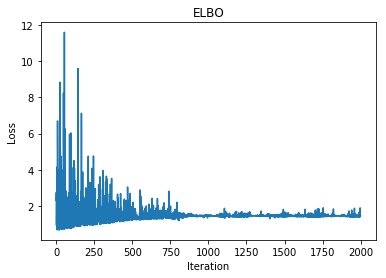

In [592]:
# SVI 
guess = 8.5

pyro.clear_param_store()

svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parameterized_guide,
                     optim=pyro.optim.Adam({"lr": 0.003}),
                     loss=pyro.infer.Trace_ELBO())

losses, a, b = [], [], []
num_steps = 2000
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("Iteration")
plt.ylabel("Loss")

print(f"a = {pyro.param('a').item()}")
print(f"b = {pyro.param('b').item()}")

Text(0, 0.5, 'b')

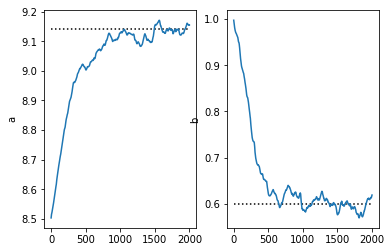

In [590]:
# parameters.
plt.subplot(1, 2, 1)
plt.plot([0, num_steps], [9.14, 9.14], "k:")
plt.plot(a)
plt.ylabel('a')

plt.subplot(1, 2, 2)
plt.plot([0, num_steps], [0.6, 0.6], "k:")
plt.plot(b)
plt.ylabel('b')

In [593]:
# pyro.condition(scale, data={"measurement": 10.0})(0.001)

# pyro.sample("measurement", pyro.distributions.Normal(pyro.sample("weight", pyro.distributions.Normal(0.9, 4)), 0.1), obs=10)
# lottery = pyro.distributions.Uniform(1, 49)

In [426]:
# Counter([lottery.sample()
# a = pyro.distributions.Categorical(torch.tensor([float(i) for i in range(1, 50)]))

In [425]:
# Counter([a.sample().item() for _ in range(10000)])

# Coin Flip

In [ ]:
def coin(p):
    return pyro.sample("coin", pyro.distributions.Bernoulli(p)).item()

In [641]:
np.mean([coin(0.5) for _ in range(1000000)])

0.500699

# Lottery Prediction


Pick 6 numbers from 1-49 as a single lottery.

In [988]:
comb(43, 5) * comb(6, 1)
#comb(49, 6)

5775588.0

In [1262]:
# Price money when we have n red balls ? 
price_money = {0: 0, 1: 0, 2: 0, 3: 5, 4: 100, 5: 2500, 6: 2000000 }

# When jackpot hits 5Millon or above.
price_money = {0: 0, 1: 0, 2: 0, 3: 50, 4: 1000, 5: 25000, 6: 5000000 }

# Probability of getting n read ball ?
expected_win_price = 0

matches = []
prices = []
probs = []
for i in range(0, 7):
    w_prob = (comb(43, 6-i) * comb(6, i)) / comb(49, 6)
    #total+= w_prob
    print(f"Probability of getting {i} red ball = {w_prob}")
    expected_win_price += w_prob * price_money[i]
    
    probs.append(w_prob)
    matches.append((i, w_prob))
    prices.append((price_money[i], w_prob))
    
print(f"Expected winning price of a single lottery is : {expected_win_price}" )

Probability of getting 0 red ball = 0.4359649755116915
Probability of getting 1 red ball = 0.4130194504847604
Probability of getting 2 red ball = 0.13237802900152576
Probability of getting 3 red ball = 0.017650403866870102
Probability of getting 4 red ball = 0.000968619724401408
Probability of getting 5 red ball = 1.8449899512407772e-05
Probability of getting 6 red ball = 7.151123842018516e-08
Expected winning price of a single lottery is : 2.669943597656033


# Probabilistic Programming

Probabilistic programming deals with uncertenities of an events.


Any outcome form an experiment can be modeled as Random Variable. Every Random variable
got a probabilistic distribution.

Here the distribution is simply a frequency count of out-comes from the experiment.
Some outcome may be happening more frequently than other one, after a while we can
see that 

# Simulate the 6/49 Lottery game

Here we are playing the 6/49 game and prooving what we have calculated analytically 
is really happening or not. Here analytically calculated means, the game can be treated
as closed form, ie; we know all the possible events happening with this game, and chances of
each every occurances. **[Validate this point ]**

In [879]:
# Lottery distribution is modeled using categorical Distribution.
lottery_dist = pyro.distributions.Categorical(
    probs=torch.tensor([1/49 for _ in range(1, 50)])
)

In [1195]:
def draw_lotter(n=1):
    return lottery_dist.sample((n, 6))

# n_loteries.apply_??
def find_matches(loteries, winning_lottery, cutoff=3):
    matching_numbers = []
    wnumbers = set(winning_number[0].tolist())
    for ind, lottery in enumerate(loteries, 1):
        match_len = len(set(lottery.tolist()).intersection(wnumbers))
        if match_len == 6:
            # Jackpot, so no
            print("You got Jackpot !!!")
        if match_len >= cutoff:
            matching_numbers.append((ind, match_len))
    return pd.DataFrame.from_records(matching_numbers, columns=["index", "num_matches"])


def lottery_roi(inv_amount, price_map, lottery_matches):
    match_count = lottery_matches.num_matches.value_counts().items()
    
    total_earned = 0
    
    for match, count in match_count:
        total_earned += count * price_map[match]
    
    #print(f"Total Earned: {total_earned}")
    #print(f"Invested: {inv_amount}")
    #print(f"Profit: {((total_earned - inv_amount) / (total_earned + 1e-10))*100 : .2f} %")
    
    expected_val = total_earned / inv_amount
    #print(f"Expected value of a Lottery Ticket: {expected_val}")
    
    return expected_val

def play_ntimes(num_lotteries, prize_money, n=1):
    """
    Play the Game buy purchasing n_lotteries from this game n times.
    
    @param num_lotteries: How many lotteries to buy in each iteration.
    @param prize_money: Map of return based on matching numbers.
    @param winning_number: The jackpot number.
    @param n: How many times play this game with above settings.
    
    eg; 
        1. We can play the game by purchasing 1 ticket 100 times and
           see how it works.
        2. By 100 tickets 1000 times.
        3. By 100K tickets 1 times.
    """
    expected_values = []
    
    for i in range(n):
        n_loteries = draw_lotter(num_lotteries).to(torch.float32)
        winning_number = draw_lotter(1).to(torch.float32)
        matches = find_matches(n_loteries, winning_number)
        expected_roi = lottery_roi(num_lotteries, prize_money, matches)
        expected_values.append(expected_roi)
        
        
    result = {
        "expected_values": expected_values,
        "num_lotteries": num_lotteries,
        "epoch": n
    }   
    return result

# Game settings


Assume you are playing the game by purchasing N number of tickets, by using our lottery model 

In [1263]:
# Play settings.
lot_size = [1000, 5000, 10000, 50000, 100000, 150000]

results = []
for lot in lot_size:
    results.append(play_ntimes(lot, price_money, n=10))
    print(lot)

1000
5000
10000
50000
100000
150000


In [1225]:
[np.mean(i["expected_values"]) for i in results]

[1.1949999999999998,
 1.5150000000000001,
 1.5665,
 1.9412000000000003,
 6.850500000000001,
 2.032666666666667]

In [1264]:
prize_df = pd.DataFrame.from_records(
    [(i["num_lotteries"], j) for i in results for j in i["expected_values"]],
    columns=["lot_size", "expected_prize_money"]
)

In [1223]:
# sns.set_style?

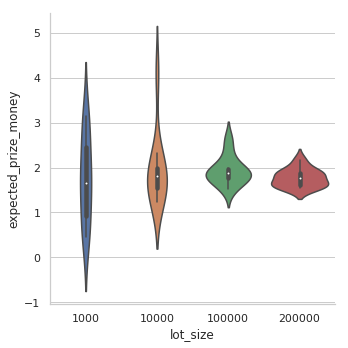

In [1222]:
sns.set_style("whitegrid")

# Case When better expectation state.
sns.catplot(x="lot_size", y="expected_prize_money", data=prize_df, kind="violin")

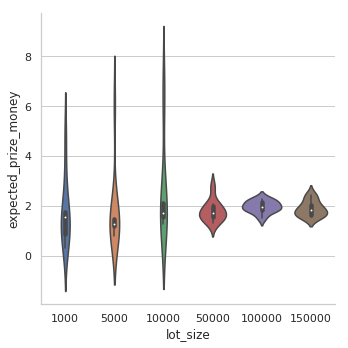

In [1234]:
# Case When better expectation state.
sns.catplot(x="lot_size", y="expected_prize_money", data=prize_df, kind="violin")

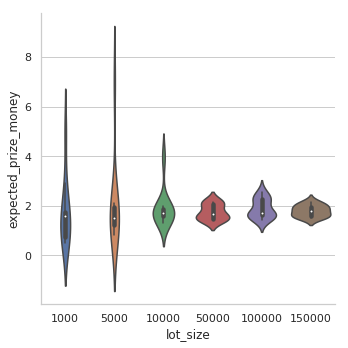

In [1267]:
# Case When better expectation state.
sns.catplot(x="lot_size", y="expected_prize_money", data=prize_df, kind="violin")

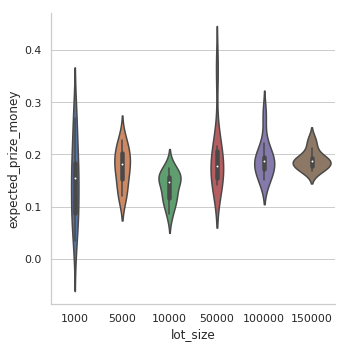

In [1241]:
# Normal game settings.
sns.catplot(x="lot_size", y="expected_prize_money", data=prize_df, kind="violin")

In [1259]:
# sns.jointplot?

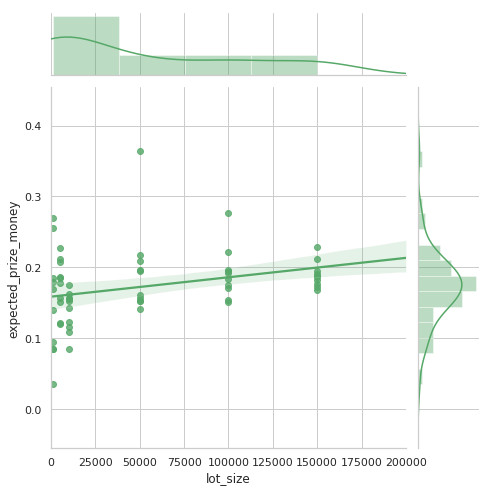

In [1260]:
sns.jointplot(x="lot_size", y="expected_prize_money",
              data=prize_df, kind="reg",
              xlim=(0, 200000),
              color="g", height=7, ratio=5
             )

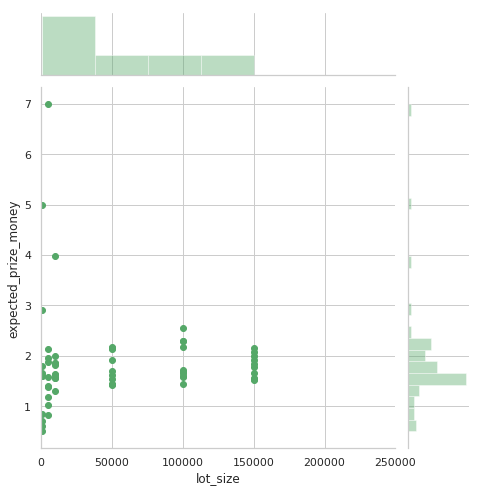

In [1269]:
sns.jointplot(x="lot_size", y="expected_prize_money",
              data=prize_df, kind="scatter",
              xlim=(0, 250000),
              color="g", height=7, ratio=5
             )

In [1082]:
# # Categories are in Long format, for torch operations turn it into float.
# num_lotteries = 8800
# n_loteries = draw_lotter(num_lotteries).to(torch.float32)
# winning_number = draw_lotter(1).to(torch.float32)

# lottery_roi(num_lotteries,
#             price_money,
#             find_matches(n_loteries, winning_number))

In [1083]:
# How many matching tickets are there.
# find_matches(n_loteries, winning_number).num_matches.value_counts()

In [ ]:
# Plot expected value of total return when buying 8800 tickets.



<BarContainer object of 6 artists>

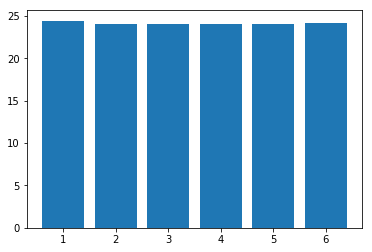

In [980]:
sample_mean = n_loteries.mean(0)
plt.bar(range(1, sample_mean.shape[0]+1), sample_mean)

In [863]:
# for i in enumerate(loteries, 1):
#     print (i)

In [984]:
# Can you measure the Shannon information for both probabilities and compare
# Beteween two methods ?

In [1003]:
# pyro.distributions.DirichletMultinomial

# Trial / Experiment 1

Here the random variable is "how many matches" a lottery ticket gets when jackpot number selected.

We analytically calculated the discreate probabilities of each events.

Fit a Descrete Poison distribution with best fit parameter. This is already a distribution ?

<BarContainer object of 7 artists>

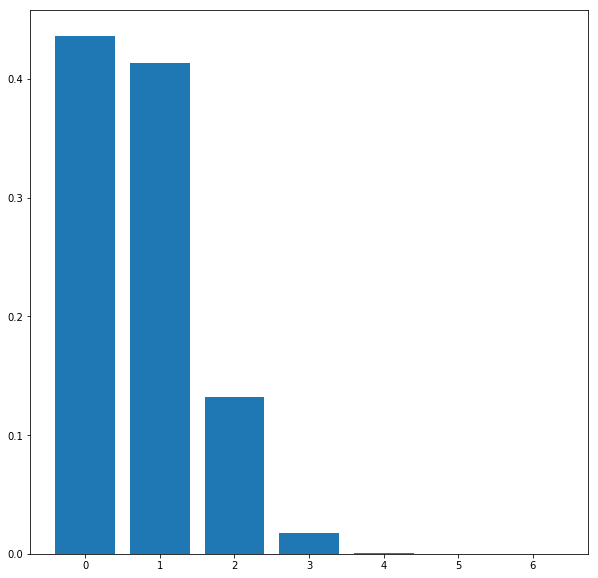

In [1035]:
plt.figure(figsize=(10,10))
plt.bar(range(0, 7), probs)

# MinHashing Algorithm 

MinHash uses the probabilistic estimatimation of the Jaccard Similarity to speed up the
similarity finding.


Let's consider two set $A$ and $B$ with set of numbers. Both $A$, and $B$ are subset of $U$

$$
U = \{ asd, work, is, done \}
$$

$A \subset U$ and $B \subset U$

$Pr(A) == Pr(B)$


Jaccard Similarity between A and B = $Jac(A,B) = 

In [1173]:
# dist.Categorical??